# Network comparison with more data - LSTM vs GRU 

In [0]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

In [2]:
""" optional: select GPU Hardware acceleration """

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Data Preparation

In [4]:
!pip install quandl

In [0]:
""" Import required classes """
import quandl 
from dataprep_class import Dataprep

prep = Dataprep()

In [6]:
quandl.ApiConfig.api_key = "Ha9a4yRKHowJC_sQxSPD"

""" commodity prices """
oil = quandl.get("EIA/PET_RWTC_D")
print(oil.head())
print(oil.shape)

gold = quandl.get("LBMA/GOLD", start_date = "1960-12-01")
print(gold.head())
print(gold.shape)

""" equity prices """
msft = quandl.get("EOD/MSFT")
print(msft.head())
print(msft.shape)

hd = quandl.get("EOD/HD")
print(hd.head())
print(hd.shape)

dis = quandl.get("EOD/DIS")
print(dis.head())
print(dis.shape)

ba = quandl.get("EOD/BA")
print(ba.head())
print(ba.shape)

aapl = quandl.get("EOD/aapl")
print(aapl.head())
print(aapl.shape)

            Value
Date             
1986-01-02  25.56
1986-01-03  26.00
1986-01-06  26.53
1986-01-07  25.85
1986-01-08  25.87
(8652, 1)
            USD (AM)  USD (PM)  GBP (AM)  GBP (PM)  EURO (AM)  EURO (PM)
Date                                                                    
1968-01-02     35.18       NaN    14.641       NaN        NaN        NaN
1968-01-03     35.16       NaN    14.617       NaN        NaN        NaN
1968-01-04     35.14       NaN    14.603       NaN        NaN        NaN
1968-01-05     35.14       NaN    14.597       NaN        NaN        NaN
1968-01-08     35.14       NaN    14.586       NaN        NaN        NaN
(13211, 6)
               Open   High    Low  ...    Adj_Low  Adj_Close   Adj_Volume
Date                               ...                                   
2013-09-03  31.7500  32.07  31.29  ...  27.160215  27.672344  154507000.0
2013-09-04  31.3900  31.47  31.11  ...  27.003972  27.077754  142320600.0
2013-09-05  31.1000  31.44  30.95  ...  26.865

Boeing shape: (1090, 1)


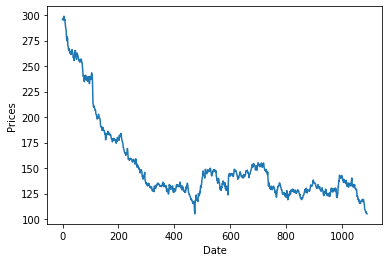

Apple shape: (1090, 1)


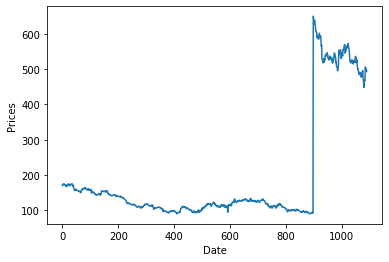

Microsoft shape: (1090, 1)


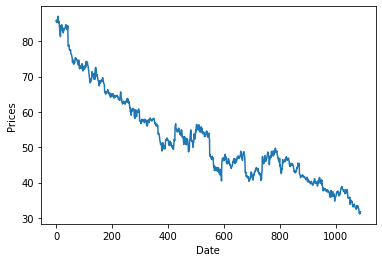

Disney shape: (1090, 1)


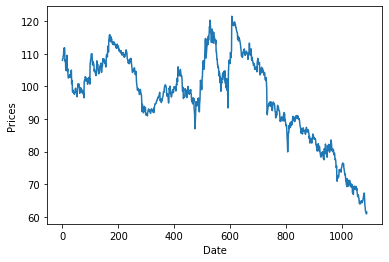

HD shape: (1090, 1)


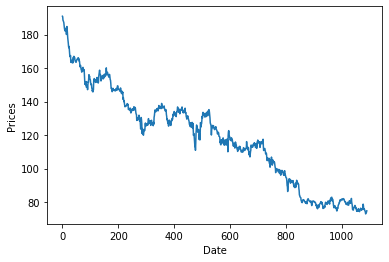

Oil shape: (8652, 1)


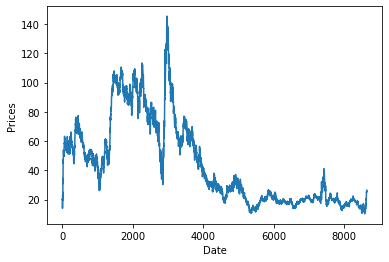

Gold shape: (13211, 1)


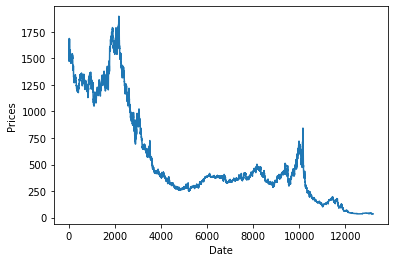

In [7]:
ba = prep.pd_to_np(ba, 1)
print("Boeing shape: " + str(ba.shape))
plt.plot(ba[:,0])
plt.xlabel("Date")
plt.ylabel("Prices")
plt.show()

aapl = prep.pd_to_np(aapl, 1)
print("Apple shape: " + str(aapl.shape))
plt.plot(aapl[:,0])
plt.xlabel("Date")
plt.ylabel("Prices")
plt.show()

msft = prep.pd_to_np(msft, 1)
print("Microsoft shape: " + str(msft.shape))
plt.plot(msft[:,0])
plt.xlabel("Date")
plt.ylabel("Prices")
plt.show()

dis = prep.pd_to_np(dis, 1)
print("Disney shape: " + str(dis.shape))
plt.plot(dis[:,0])
plt.xlabel("Date")
plt.ylabel("Prices")
plt.show()

hd = prep.pd_to_np(hd, 1)
print("HD shape: " + str(hd.shape))
plt.plot(hd[:,0])
plt.xlabel("Date")
plt.ylabel("Prices")
plt.show()

oil = prep.pd_to_np(oil, 1)
print("Oil shape: " + str(oil.shape))
plt.plot(oil[:,0])
plt.xlabel("Date")
plt.ylabel("Prices")
plt.show()

gold = prep.pd_to_np(gold, 1)
print("Gold shape: " + str(gold.shape))
plt.plot(gold[:,0])
plt.xlabel("Date")
plt.ylabel("Prices")
plt.show()

In [9]:
datasets = [aapl, msft, dis, hd, oil, gold]
data = np.array([]).reshape((-1,1))
for dataset in datasets:
  np.flip(dataset, axis = 0)
  data = prep.concat(data, dataset)
 
print(data.shape)

(26223, 1)


In [10]:
scaled_data, scaler = prep.scaling(data, "MinMax")
price_history , labels = prep.sliding_windows(scaled_data, wsize = 60, stepsize = 1)
x_train, y_train, x_test, y_test, x_val, y_val = prep.train_test_split(price_history, labels, train_percent = 0.85, validation = True, val_percent = 0.05)

x_train = prep.rnn_reshape(x_train)
x_test = prep.rnn_reshape(x_test)
x_val = prep.rnn_reshape(x_val)

print("Split data into train and test sets, reshape for RNNs:")
print("Train sets shape - X:"+str(x_train.shape)+"   Y: "+str(y_train.shape))
print("Test sets shape - X:"+str(x_test.shape)+"   Y: "+str(y_test.shape))
print("Validation sets shape - X:"+str(x_val.shape)+"   Y: "+str(y_val.shape))

Split data into train and test sets, reshape for RNNs:
Train sets shape - X:(22237, 60, 1)   Y: (22237, 1)
Test sets shape - X:(2617, 60, 1)   Y: (2617, 1)
Validation sets shape - X:(1308, 60, 1)   Y: (1308, 1)


# Keras Model definition

In [0]:
""" Define Model class to implement LSTM and GRU network """

class RNN():
  
  """ RNN with gated recurrent units """
  def build_GRU(self, layers, units, timesteps, loss = 'mean_squared_error', dropout = True, l2_reg = False, dropout_rate = 0.2):
        """
        Parameters
        ----------
        layers : integer - how many LSTM layers to use
        units : integer - how many units per LSTM layer
        timesteps : x_train.shape[1] (time steps per input frame)
        loss : loss function
        dropout : bool - use dropout or not
        l2_reg : bool - use L2 regularization or not
        dropout_rate : float between zero and one
        -------
        returns: compiled LSTM model
        """
        if layers <= 0 or units <= 0:
            raise ValueError("layers and units cannot be smaller or equal to zero")
        
        if 0 > dropout_rate or dropout_rate > 1:
            raise ValueError("dropout rate must be between zero and 1")

        if l2_reg:
            reg = keras.regularizers.l2(0.001)
        else:
            reg = None

        if not dropout:
            dropout_rate = 0
        

        model = keras.models.Sequential()

        if layers == 1:
            model.add(keras.layers.GRU(units = 50, return_sequences = False, kernel_regularizer = reg, input_shape = (timesteps, 1))) 
            model.add(keras.layers.Dropout(dropout_rate))
        

        else:
            model.add(keras.layers.GRU(units = 50, return_sequences = True, kernel_regularizer = reg, input_shape = (timesteps, 1))) 
            model.add(keras.layers.Dropout(dropout_rate))

            for i in range(layers - 2):
                model.add(keras.layers.GRU(units = 50, return_sequences = True, kernel_regularizer = reg)) 
                model.add(keras.layers.Dropout(dropout_rate))
            
            model.add(keras.layers.GRU(units = 50, return_sequences = False, kernel_regularizer = reg)) 
            model.add(keras.layers.Dropout(dropout_rate))

        model.add(keras.layers.Dense(1, activation = 'relu'))

        optimizer = keras.optimizers.Adam(learning_rate = 0.0075, epsilon = 1e-08)
        loss = keras.losses.mean_squared_error
        model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

        return model

  """ RNN with long-short-term-memmory units """
  def build_LSTM(self, layers, units, timesteps, loss = 'mean_squared_error', dropout = True, l2_reg = False, dropout_rate = 0.2):
        """
        Parameters
        ----------
        layers : integer - how many LSTM layers to use
        units : integer - how many units per LSTM layer
        timesteps : x_train.shape[1] (time steps per input frame)
        loss : loss function
        dropout : bool - use dropout or not
        l2_reg : bool - use L2 regularization or not
        dropout_rate : float between zero and one
        -------
        returns: compiled LSTM model
        """
        if layers <= 0 or units <= 0:
            raise ValueError("layers and units cannot be smaller or equal to zero")
        
        if 0 > dropout_rate or dropout_rate > 1:
            raise ValueError("dropout rate must be between zero and 1")

        if l2_reg:
            reg = keras.regularizers.l2(0.001)
        else:
            reg = None

        if not dropout:
            dropout_rate = 0
        

        model = keras.models.Sequential()

        if layers == 1:
            model.add(keras.layers.LSTM(units = 50, return_sequences = False, kernel_regularizer = reg, input_shape = (timesteps, 1))) 
            model.add(keras.layers.Dropout(dropout_rate))
        

        else:
            model.add(keras.layers.LSTM(units = 50, return_sequences = True, kernel_regularizer = reg, input_shape = (timesteps, 1))) 
            model.add(keras.layers.Dropout(dropout_rate))

            for i in range(layers - 2):
                model.add(keras.layers.LSTM(units = 50, return_sequences = True, kernel_regularizer = reg)) 
                model.add(keras.layers.Dropout(dropout_rate))
            
            model.add(keras.layers.LSTM(units = 50, return_sequences = False, kernel_regularizer = reg)) 
            model.add(keras.layers.Dropout(dropout_rate))

        model.add(keras.layers.Dense(1, activation = 'relu'))

        optimizer = keras.optimizers.Adam(learning_rate = 0.0075, epsilon = 1e-08)
        loss = keras.losses.mean_squared_error
        model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

        return model


# Build and Train Models

We will now train two models - use same activation functions (relu) and an Adam optimizer with learning rate 0.0075, evaluate on MSE function

First, we build and train the network using a gated recurrent unit architecture

In [15]:
timesteps = x_train.shape[1]

net = RNN()

""" build GRU model with 3 layers and 50 units, dropout 0.2, no L2 reg """

gru_model = net.build_GRU(3, 50, timesteps)

gru_model.fit(x_train, y_train, epochs = 27, validation_data = (x_val, y_val))

Epoch 1/59
695/695 [==============================] - 11s 16ms/step - loss: 0.0016 - accuracy: 8.9940e-05 - val_loss: 5.4981e-04 - val_accuracy: 0.0000e+00
Epoch 2/59
695/695 [==============================] - 10s 14ms/step - loss: 8.1975e-04 - accuracy: 8.9940e-05 - val_loss: 1.4763e-04 - val_accuracy: 0.0000e+00
Epoch 3/59
695/695 [==============================] - 10s 14ms/step - loss: 7.6280e-04 - accuracy: 8.9940e-05 - val_loss: 5.3966e-04 - val_accuracy: 0.0000e+00
Epoch 4/59
695/695 [==============================] - 10s 14ms/step - loss: 6.6648e-04 - accuracy: 8.9940e-05 - val_loss: 8.1837e-05 - val_accuracy: 0.0000e+00
Epoch 5/59
695/695 [==============================] - 10s 15ms/step - loss: 7.6484e-04 - accuracy: 8.9940e-05 - val_loss: 2.3578e-04 - val_accuracy: 0.0000e+00
Epoch 6/59
695/695 [==============================] - 10s 15ms/step - loss: 7.3541e-04 - accuracy: 8.9940e-05 - val_loss: 2.2440e-04 - val_accuracy: 0.0000e+00
Epoch 7/59
695/695 [========================

Next, we build and train another network - this time using an LSTM architecture

In [0]:
""" build LSTM model with 3 layers and 50 units, dropout 0.2, no L2 reg """

lstm_model = net.build_LSTM(3, 50, timesteps)

lstm_model.fit(x_train, y_train, epochs = 27, validation_data = (x_val, y_val))